# Verilog FSM Sequence Detector Automation

In [12]:
def generate_verilog(sequence, module_name="seq_detector"):
    n = len(sequence)
    num_states = n + 1   # S0..Sn
    bits = (num_states-1).bit_length()  # binary width

    # Generate state names
    states = [f"S{i}" for i in range(num_states)]

    verilog = []
    verilog.append(f"module {module_name}(input clk, input reset, input din, output reg detected);\n")

    # Parameter state encoding
    verilog.append("  // State encoding")
    for i, s in enumerate(states):
        verilog.append(f"  parameter {s} = {bits}'d{i};")

    verilog.append(f"\n  reg [{bits-1}:0] state, next_state;\n")

    # Sequential block
    verilog.append("  always @(posedge clk or posedge reset) begin")
    verilog.append("    if (reset)")
    verilog.append(f"      state <= {states[0]};")
    verilog.append("    else")
    verilog.append("      state <= next_state;")
    verilog.append("  end\n")

    # Next-state logic
    verilog.append("  always @(*) begin")
    verilog.append("    detected = 0;")
    verilog.append("    case (state)")

    for i in range(num_states):
        verilog.append(f"      {states[i]}: begin")
        if i == n:
            # Final state → detection
            verilog.append("        detected = 1;")
            # Overlap handling
            for b in ['0','1']:
                suffix = sequence[1:] + b
                next_state = 0
                for k in range(n,0,-1):
                    if sequence[:k] == suffix[-k:]:
                        next_state = k
                        break
                verilog.append(f"        if (din == 1'b{b}) next_state = {states[next_state]};")
        else:
            for b in ['0','1']:
                if b == sequence[i]:
                    verilog.append(f"        if (din == 1'b{b}) next_state = {states[i+1]};")
                else:
                    # Fallback
                    suffix = sequence[:i] + b
                    next_state = 0
                    for k in range(i,0,-1):
                        if sequence[:k] == suffix[-k:]:
                            next_state = k
                            break
                    verilog.append(f"        if (din == 1'b{b}) next_state = {states[next_state]};")
        verilog.append("      end")

    verilog.append("      default: next_state = S0;")
    verilog.append("    endcase")
    verilog.append("  end\nendmodule")

    return "\n".join(verilog)


# Test Bench Automation

In [17]:
def generate_testbench(sequence, module_name="seq_detector", tb_name="tb_seq_detector", test_stream="1011011001011"):
    tb = []
    tb.append(f"module {tb_name};")
    tb.append("  reg clk, reset, din;")
    tb.append("  wire detected;")
    tb.append(f"  {module_name} uut (.clk(clk), .reset(reset), .din(din), .detected(detected));")
    tb.append("")
    # Clock generation
    tb.append("  initial begin")
    tb.append("    clk = 0;")
    tb.append("    forever #5 clk = ~clk;")
    tb.append("  end")
    tb.append("")
    # Stimulus
    tb.append("  initial begin")
    tb.append("    $dumpfile(\"wave.vcd\");")
    tb.append("    $dumpvars(0, uut);")
    tb.append("    reset = 1; din = 0; #12;")
    tb.append("    reset = 0;")
    tb.append(f"    // Test stream: {test_stream}")
    for bit in test_stream:
        tb.append(f"    din = 1'b{bit}; #10;")
    tb.append("    #20; $finish;")
    tb.append("  end")
    tb.append("endmodule")
    return "\n".join(tb)


# Example

In [22]:
sequence = "100111"
module_name = "seq100111_detector"

verilog_code = generate_verilog(sequence, module_name)
testbench_code = generate_testbench(sequence, module_name, "tb_seq100111", test_stream="100111001111001011110011110011100111")

with open(f"{module_name}.v", "w") as f:
    f.write(verilog_code)

with open(f"{module_name}_tb.v", "w") as f:
    f.write(testbench_code)

print(f"Generated {module_name}.v and {module_name}_tb.v")

Generated seq100111_detector.v and seq100111_detector_tb.v


# Run the test bench and generate the GTKWave file

After generating the Verilog and testbench files, run the following cell to compile and simulate your design. This will produce a `wave.vcd` file, which you can open with GTKWave to view the waveform and verify the sequence detector's operation.

In [23]:
!iverilog -o sim seq{sequence}_detector.v seq{sequence}_detector_tb.v
!vvp sim
!gtkwave wave.vcd


VCD info: dumpfile wave.vcd opened for output.
seq100111_detector_tb.v:53: $finish called at 392 (1s)
WM Destroy



GTKWave Analyzer v3.3.100 (w)1999-2019 BSI

[0] start time.
[392] end time.


# Example Output
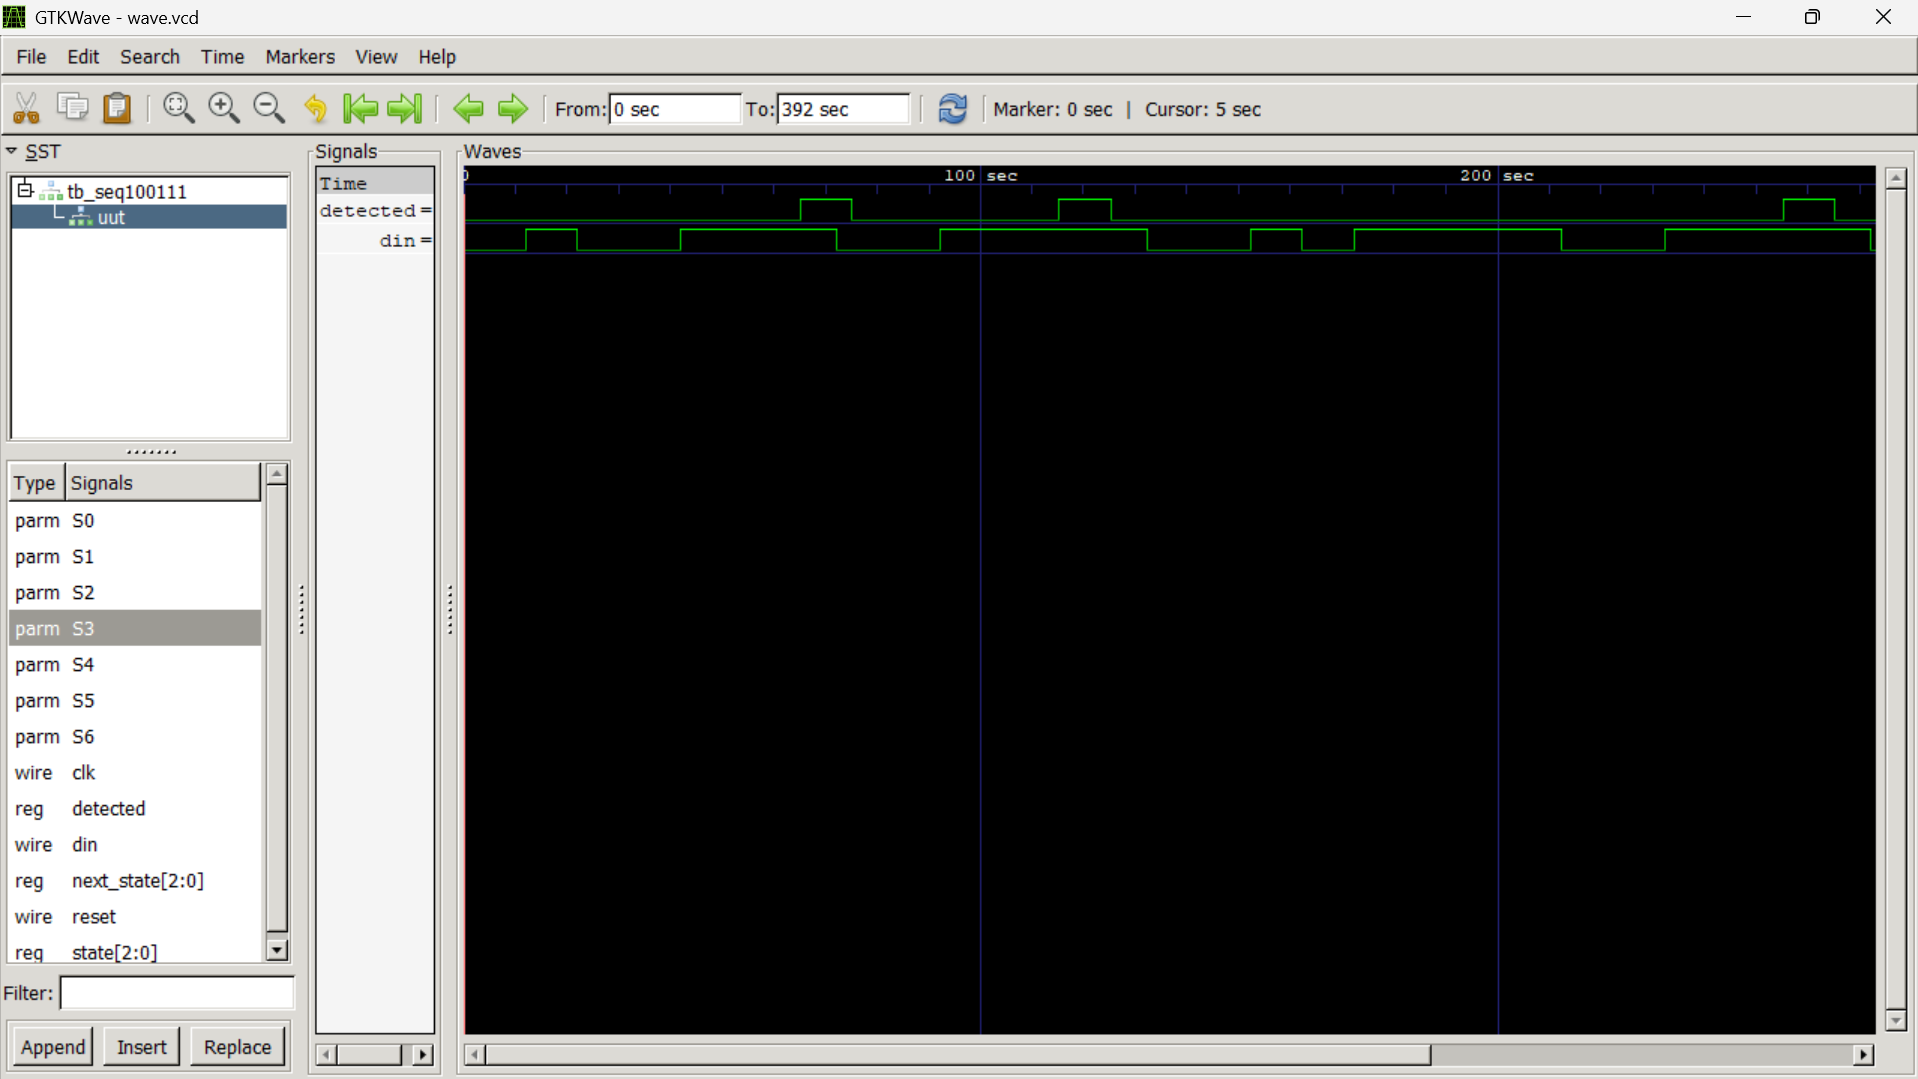